-   [Creating informative visualisations of genomic regions from a set
    of `.bam`
    files](#creating-informative-visualisations-of-genomic-regions-from-a-set-of-.bam-files)
    -   [Setting Up](#setting-up)
    -   [Defining the plotting
        function](#defining-the-plotting-function)
    -   [Creating plots of example data for the DNMT3A
        gene](#creating-plots-of-example-data-for-the-dnmt3a-gene)
    -   [Exercises](#exercises)

Creating informative visualisations of genomic regions from a set of `.bam` files
=================================================================================

In this workflow we will create overview plots of genomic regions that give an overview of the coverage and mismatches in a set of `.bam` files in a given genomic region. An example plot is shown here:

Setting Up
----------

The following Bioconductor packages are needed for this workflow:

In [1]:
require(BiocInstaller)
biocLite(c("h5vc", "h5vcData", "BSgenome.Hsapiens.NCBI.GRCh38")

ERROR: Error in parse(text = x, srcfile = src): <text>:3:0: unexpected end of input
1: require(BiocInstaller)
2: biocLite(c("h5vc", "h5vcData", "BSgenome.Hsapiens.NCBI.GRCh38")
  ^


Typically an HDF5 tally file will store the nucleotide tally data and the accompanying sample data and the functions for plotting defined in the `h5vc` package. If we do not want to create an HDF5 file representation of our data, we can define a new function that makes sure that the data and sample data are present in the correct format.

First we load the required packages, `h5vc` for plotting and `BSgenome.Hsapiens.NCBI.GRCh38` to provide the reference genome sequence. We use `BSgenome.Hsapiens.NCBI.GRCh38` because the example `.bam` files that I will use here are aligned against that revision of the human reference genome. You should use an appropriate genome object here, e.g. if you want to work in *Arabidopsis Thaliana* instead you would maybe use the `BSgenome.Athaliana.TAIR.TAIR9` package instead.

In [2]:
require(h5vc)
require(BSgenome.Hsapiens.NCBI.GRCh38)

Loading required package: h5vc
Loading required package: grid
Loading required package: gridExtra
Loading required package: ggplot2
Loading required package: BSgenome.Hsapiens.NCBI.GRCh38
Loading required package: BSgenome
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rown

Next we find our example data `.bam` files and create a `sampleData` object that is simply a `data.frame` describing the samples we want to work with.

In [3]:
files <- list.files( system.file("extdata", package = "h5vcData"), "Pt.*bam$" )
bamFiles <- file.path( system.file("extdata", package = "h5vcData"), files)

sampleData <- data.frame(
  SampleFiles = files,
  Sample = sapply(strsplit(files, split = "\\."), function(x) x[1]),
  Type = rep(c("Case", "Control"), length(files)/2),
  Column = seq(length(files)),
  Patient = substr(files, 1, 4),
  stringsAsFactors = FALSE #Silly, but important to get the track labels right
  )

sampleData

,SampleFiles,Sample,Type,Column,Patient
1,Pt10Cancer.bam,Pt10Cancer,Case,1,Pt10
2,Pt10Control.bam,Pt10Control,Control,2,Pt10
3,Pt17Cancer.bam,Pt17Cancer,Case,3,Pt17
4,Pt17Control.bam,Pt17Control,Control,4,Pt17
5,Pt18Cancer.bam,Pt18Cancer,Case,5,Pt18
6,Pt18Control.bam,Pt18Control,Control,6,Pt18
7,Pt20Cancer.bam,Pt20Cancer,Case,7,Pt20
8,Pt20Control.bam,Pt20Control,Control,8,Pt20
9,Pt23Cancer.bam,Pt23Cancer,Case,9,Pt23
10,Pt23Control.bam,Pt23Control,Control,10,Pt23


Defining the plotting function
------------------------------

Finally we define the `plotBAMs` function that will take a `GRanges` object describing the genomic intervals we want to plot, the list of `.bam` files, the `sampleData` object and the reference object (that will be `BSgenome.Hsapiens.NCBI.GRCh38` in our case).

In [4]:
plotBAMs <- function( ranges, bamFiles, sampleData, reference){
  require(h5vc)
  theData <- tallyRanges( bamFiles, ranges = ranges, reference = reference )
  for( idx in seq(length(ranges))){ # This is needed since we dont use HDF5 to store the data
    theData[[idx]]$h5dapplyInfo <- list( Blockstart = start(ranges[idx]), Blockend = end(ranges[idx]))
  }
  mismatchPlot(
    theData, sampleData
    )
}

Creating plots of example data for the DNMT3A gene
--------------------------------------------------

Here we define the genomic ranges we will want to plot, they correspond to exons of the DNMT3A gene in our example. The `GRanges` should come from a VCF file with variant calls when we want to visualise variant calls, but for the sake of this example the DNMT3A exons will suffice.

In [5]:
require(GenomicRanges)
dnmt3a <- read.table(system.file("extdata", "dnmt3a.txt", package = "h5vcData"), header=TRUE, stringsAsFactors = FALSE)
dnmt3a <- with( dnmt3a, GRanges(seqname, ranges = IRanges(start = start, end = end)))
dnmt3a <- reduce(dnmt3a)
dnmt3a

GRanges object with 29 ranges and 0 metadata columns:
       seqnames               ranges strand
          <Rle>            <IRanges>  <Rle>
   [1]        2 [25227855, 25234420]      *
   [2]        2 [25235706, 25235825]      *
   [3]        2 [25236930, 25237005]      *
   [4]        2 [25239130, 25239215]      *
   [5]        2 [25239315, 25239513]      *
   ...      ...                  ...    ...
  [25]        2 [25300139, 25300243]      *
  [26]        2 [25313913, 25314161]      *
  [27]        2 [25328633, 25328744]      *
  [28]        2 [25341826, 25341885]      *
  [29]        2 [25342430, 25342590]      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

Let's plot some DNMT3A exons (2,3 and 4) in the first 4 samples (the object `Hsapiens` is defined in the `BSgenome.Hsapiens.NCBI.GRCh38` package and contains the genomic reference sequence2):

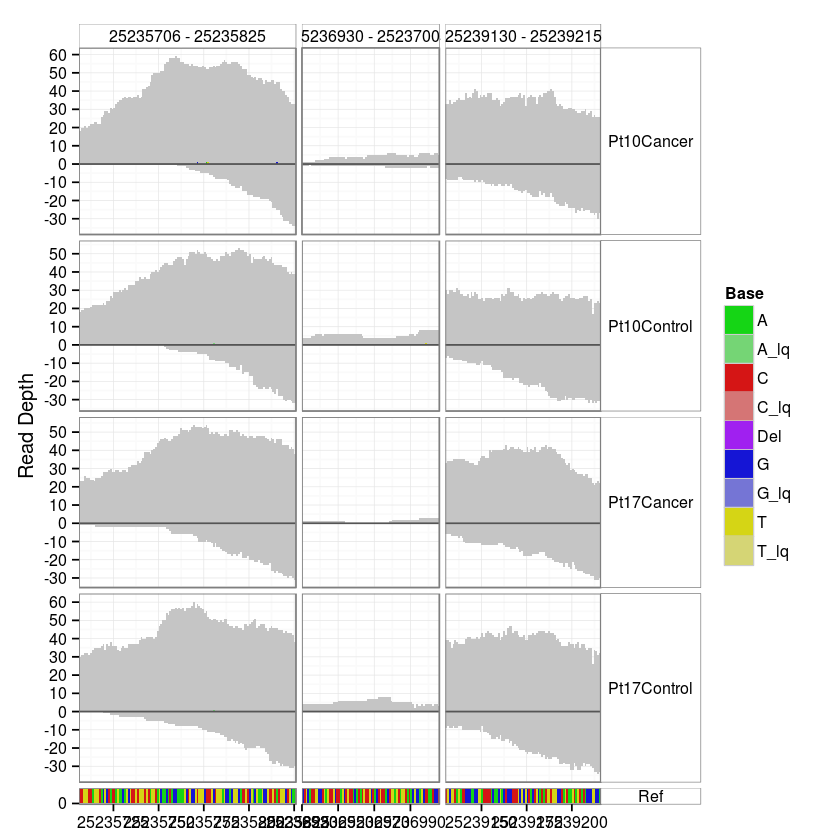

In [6]:
p <- plotBAMs(
  ranges = dnmt3a[2:4],
  bamFiles = bamFiles[1:4],
  sampleData = sampleData[1:4,],
  reference = Hsapiens
  )
print(p)

`p` is a ggplot object, so we can modify how it looks by adding theme commands and so on:

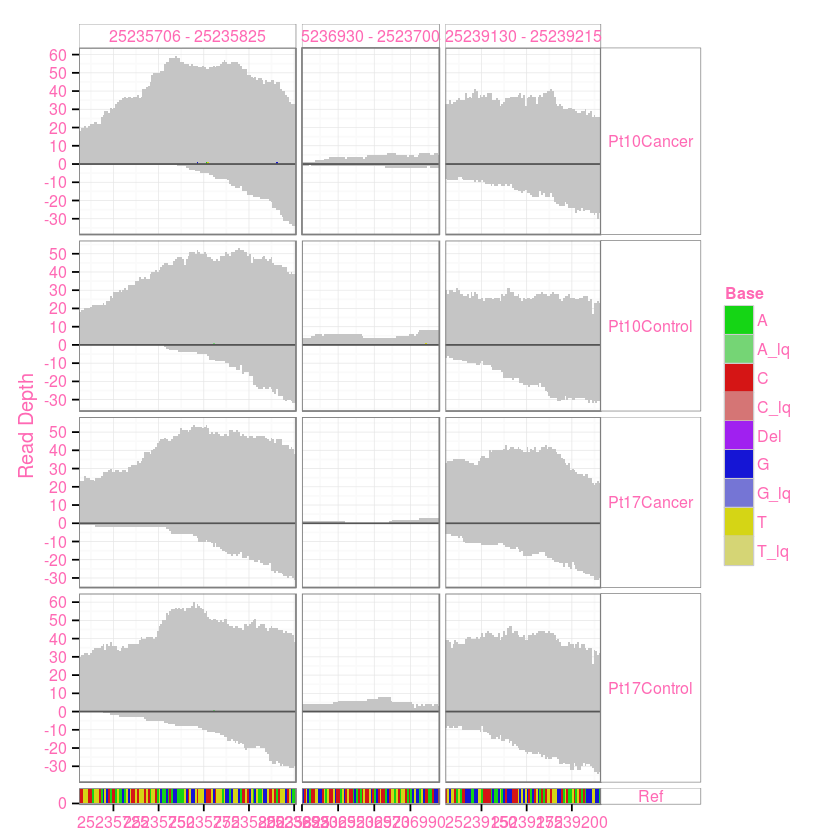

In [7]:
print(p + theme(text = element_text(colour = "hotpink"))) 

Hmm, maybe making the text pink wasn't the best idea, let's try something else:

In [8]:
## setting Jupyter plotting size
options(repr.plot.height=10,repr.plot.width=16)

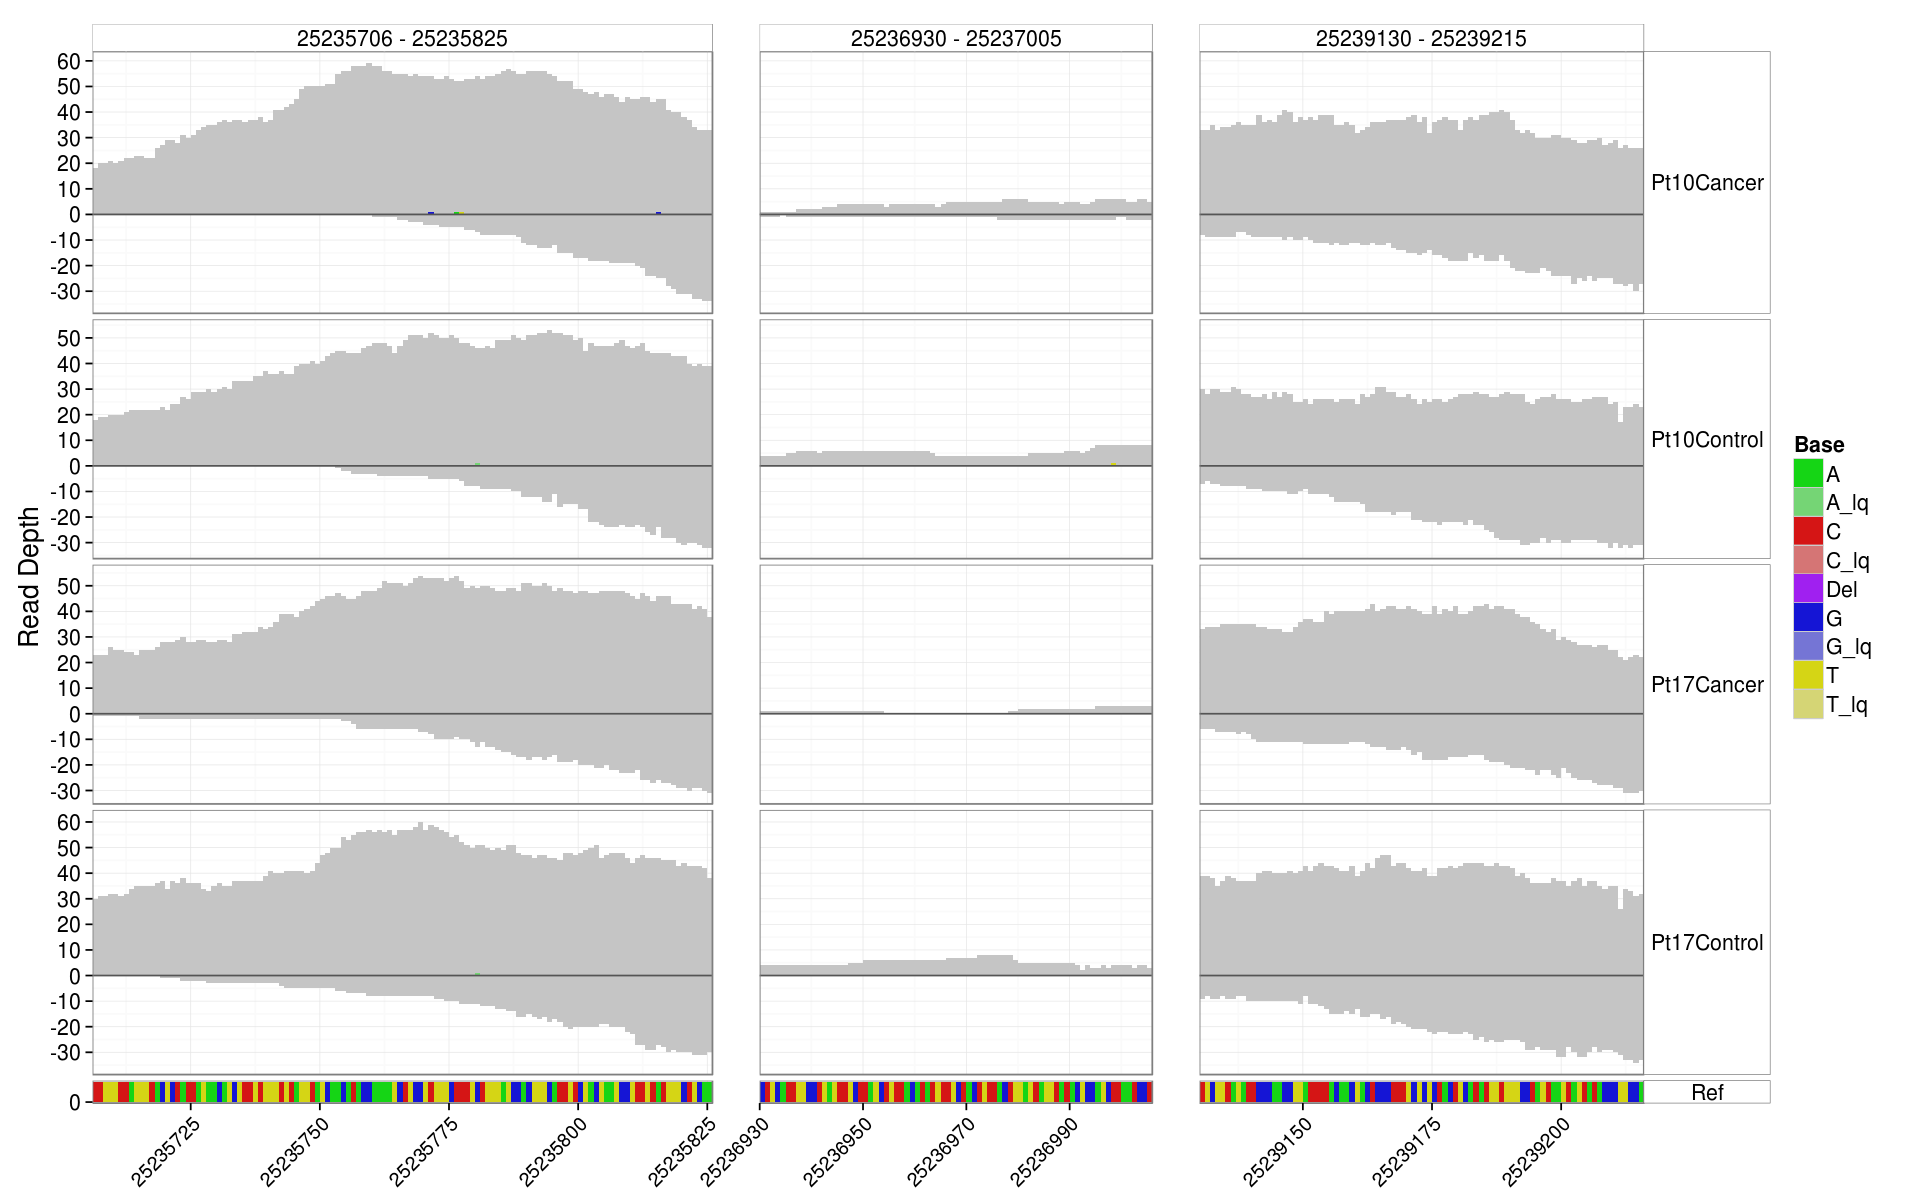

In [9]:
print(p + theme(text = element_text(size = 16), axis.text.x = element_text(angle = 45, size = 12, vjust = 1, hjust = 1), panel.margin.x = unit(1, units = "cm"))) 

Exercises
---------

1.  Apply your knowledge of creating shiny apps to create a browser-app. This app should let you select which samples and exons (of DNMT3A) should be plotted and then display the selected region.
2.  Use your knowledge of the `VariantAnnotation` package to implement a shiny app or set of functions that loads a VCF file and plots ranges around the variants. You might need a set of appropriate `.bam` files to do this, i.e. `.bam` files that contain the data that gave rise to the variant calls in your VCF file.